<a href="https://colab.research.google.com/github/avnishere/Brain_Computer_Interface/blob/master/starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset information
ref: http://bbci.de/competition/iii/desc_V.html

## Experiment

This dataset contains data from 3 normal subjects during 4 non-feedback sessions. The subjects sat in a normal chair, relaxed arms resting on their legs. There are 3 tasks:
1. Imagination of repetitive self-paced left hand movements, (_left_, class 2),
2. Imagination of repetitive self-paced right hand movements, (_right_, class 3),
3. Generation of words beginning with the same random letter, (_word_, class 7).

All 4 sessions of a given subject were acquired on the same day, each lasting 4 minutes with 5-10 minutes breaks in between them. The subject performed a given task for about 15 seconds and then switched randomly to another task at the operator's request. EEG data is not splitted in trials since the subjects are continuously performing any of the mental tasks. The algorithm should provide an output every 0.5 seconds using the last second of data (see clarification in the paragraph 'Requirements and Evaluation'.) Data are provided in two ways:
1. _Raw EEG_ signals. Sampling rate was 512 Hz.
2. _Precomputed_ features. The raw EEG potentials were first spatially filtered by means of a surface Laplacian. Then, every 62.5 ms --i.e., 16 times per second-- the power spectral density (PSD) in the band 8-30 Hz was estimated over the last second of data with a frequency resolution of 2 Hz for the 8 centro-parietal channels C3, Cz, C4, CP1, CP2, P3, Pz, and P4. As a result, an EEG sample is a 96-dimensional vector (8 channels times 12 frequency components).

## Format of the Data

For each subject there are 3 training files and 1 testing file (the last recording session). Training files are labelled while testing files are not. Data are provided in ASCII format.
- _Precomputed features_: files contain a PSD sample per row (i.e., the first 12 components are the PSD in the band 8-30 Hz at channel C3, and so on, for a total of 96 components). The number of PSD samples are:

| &nbsp; | **Training** | **Testing** |
| --- | :---: | :---: |
| Subject 1 | 3488/3472/3568 | 3504 |
| Subject 2 | 3472/3456/3472 | 3472 |
| Subject 3 | 3424/3424/3440 | 3488 |

- _Raw EEG signals_: each line of the files contains the 32 EEG potentials acquired at a given time instant in the order: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, O1, Oz, O2, PO4, P4, P8, CP6, CP2, C4, T8, FC6, FC2, F4, F8, AF4, Fp2, Fz, Cz. In the training files, each line has a 33rd component indicating the class label.

## Requirements and Evaluation

Please provide your estimated class labels (2, 3, or 7) for every input vector of the 3 test files (one per subject). The labels must be estimated in the following way:

- **Precomputed features:** Since input vectors are computed 16 times per second, provide the average of 8 consecutive samples (so that to get a response every 0.5 seconds). Other (i.e. also past) samples must not be used in order to guarantee a fast response times of the system, although for the competition test data set averaging over more samples could be of benefit.

- **Raw signals:** Compute vectors 16 times per second using the last second of data. Then provide the average of 8 consecutive samples (so that to get a response every 0.5 seconds). Other (i.e. also past) samples must not be used in order to guarantee a fast response times of the system, although for the competition test data set averaging over more samples could be of benefit.

Also give a description of the used algorithm. The performance measure is the classification accuracy (correct classification divided by the total number of samples) averaged over the 3 subjects. 
There will be a special prize to the best algorithm working with the precomputed samples (in the case it does not achieve the best absolute result).

## Technical Information

EEG signals were recorded with a Biosemi system using a cap with 32 integrated electrodes located at standard positions of the International 10-20 system. The sampling rate was 512 Hz. Signals were acquired at full DC. No artifact rejection or correction was employed.

Notes:

*   Continuous, multi-class dataset.
*   8 channels (electrode positions) * 12 frequencies (8:2:30 Hz) = 96 dimensional vector
*   Small data size

---
# Main Tasks

In [0]:
import os
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle
from collections import Counter
import re

## Read Data

### Mount google drive

In [0]:
# Mount Google drive
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/gdrive')

In [0]:
# Here you must try by yourself where the path to the dataset folder is !!
# e.g. !ls "gdrive/My Drive/Colab Notebooks/DME/datasets"
!ls "gdrive"

'My Drive'


In [0]:
# Then assign the path here.
# This is the path for my GG drive, change it according to your path
# dataset_path = "gdrive/My Drive/Colab Notebooks/DME/datasets"

# Your folder path here
dataset_path = "gdrive/My Drive/Colab Notebooks/DME/datasets"

### Read data from csv

In [0]:
try:
  dataset_path
except:
  dataset_path = os.path.join(os.getcwd(), 'datasets')

df_train_pcf = pd.read_csv(os.path.join(dataset_path, 'df_train_pcf.csv'))
df_test_pcf = pd.read_csv(os.path.join(dataset_path, 'df_test_pcf.csv'))
df_train_raw = pd.read_csv(os.path.join(dataset_path, 'df_train_raw.csv'))
df_test_raw = pd.read_csv(os.path.join(dataset_path, 'df_test_raw.csv'))

label_dict = {2: 'left', 3: 'right', 7: 'word'}
df_train_pcf.replace({'label' : label_dict}, inplace=True)
df_train_raw.replace({'label' : label_dict}, inplace=True)

pcf_setup = pickle.load(open(os.path.join(dataset_path, 'pcf_setup.obj'), "rb"))
raw_setup = pickle.load(open(os.path.join(dataset_path, 'raw_setup.obj'), "rb"))

pcf_channels = pcf_setup['channels']
raw_channels = raw_setup['channels']

### !!! Skip this step !!! if no needs of MAT files !!!
### Read data from seperated mat files

In [0]:
def load_datasets(filenames, folder=os.path.join(os.getcwd(), 'datasets'), mapping_fn=None, test=False):
    list_df = []
    for file in filenames:
        path = os.path.join(folder, file)
        mat = loadmat(path)
        list_df.append(mat_to_df(mat, mapping_fn=mapping_fn, ignore_label=test))
    return pd.concat(list_df, ignore_index=True)

def psd_mapping(mat):
    # Return X, Y, filename, channels, n_components
    return {
        'X': mat.get('X'),
        'Y': mat.get('Y'),
        'filename': mat['nfo']['name'][0][0][0],
        'channels': [c for [c] in mat['nfo']['clab'][0][0][0]],
        'n_components': 12,
        'fs': mat['nfo']['fs'][0][0][0][0],
        'xpos': mat['nfo']['xpos'][0][0].reshape(-1),
        'ypos': mat['nfo']['ypos'][0][0].reshape(-1)
    }

def raw_eeg_mapping(mat):
    # Return X, Y, filename, channels, n_components
    return {
        'X': mat.get('X'),
        'Y': mat.get('Y'),
        'filename': mat['nfo']['name'][0][0][0],
        'channels': [c for [c] in mat['nfo']['clab'][0][0][0]],
        'n_components': 1,
        'fs': mat['nfo']['fs'][0][0][0][0],
        'xpos': mat['nfo']['xpos'][0][0].reshape(-1),
        'ypos': mat['nfo']['ypos'][0][0].reshape(-1)
    }

def mat_to_df(mat, mapping_fn=None, ignore_label=False):

    assert callable(mapping_fn), "Missing mapping function (mapping_fn).\nInput: mat\nOutput: X, Y, filename, channels, n_components"

    data = mapping_fn(mat)
    X = data['X']
    Y = data['Y']
    filename = data['filename']
    channels = data['channels']
    n_components = data['n_components']

    pattern = '^(?:train|test)_subject(\d+)_\w+?(\d+)$'
    match = re.search(pattern, filename)

    assert match is not None, "Filename does not match regex '{}'".format(pattern)

    subject = int(match.group(1))
    session = int(match.group(2))

    n_rows, n_cols = X.shape

    if n_components > 1:
        columns = ["{}_{}".format(c,i+1) for c in channels for i in range(n_components) ] + ['subject', 'session']
    else:
        columns = channels + ['subject', 'session']
    dtypes = [np.float64] * n_cols + [np.uint8] * 3
    mixed_data = np.hstack((
        X,
        subject * np.ones((n_rows, 1), dtype=int),
        session * np.ones((n_rows, 1), dtype=int),
    ))

    if ignore_label == False:
        assert Y is not None, "Missing label data.\nSolution: mat_to_df(mat, ignore_label=True)"
        columns += ['label']
        dtypes += [np.uint8]
        mixed_data = np.hstack((mixed_data, Y))

    df = pd.DataFrame(mixed_data, columns=columns)
    df = df.astype(dict(zip(columns, dtypes)))
    return df

def extract_channels(filename, folder=os.path.join(os.getcwd(), 'datasets'), mapping_fn=None):
    path = os.path.join(folder, filename)
    mat = loadmat(path)
    data = mapping_fn(mat)
    return data['channels']

def extract_setup(filename, folder=os.path.join(os.getcwd(), 'datasets'), mapping_fn=None):
    path = os.path.join(folder, filename)
    mat = loadmat(path)
    setup = ['channels', 'fs', 'xpos', 'ypos']
    return {k: v for k, v in mapping_fn(mat).items() if k in setup}


In [0]:
train_precomputed_features_data_files = [
    'train_subject1_psd01.mat',
    'train_subject1_psd02.mat',
    'train_subject1_psd03.mat',
    'train_subject2_psd01.mat',
    'train_subject2_psd02.mat',
    'train_subject2_psd03.mat',
    'train_subject3_psd01.mat',
    'train_subject3_psd02.mat',
    'train_subject3_psd03.mat'
]
test_precomputed_features_data_files = [
    'test_subject1_psd04.mat',
    'test_subject2_psd04.mat',
    'test_subject3_psd04.mat'
]
train_raw_eeg_signals_data_files = [
    'train_subject1_raw01.mat',
    'train_subject1_raw02.mat',
    'train_subject1_raw03.mat',
    'train_subject2_raw01.mat',
    'train_subject2_raw02.mat',
    'train_subject2_raw03.mat',
    'train_subject3_raw01.mat',
    'train_subject3_raw02.mat',
    'train_subject3_raw03.mat'
]
test_raw_eeg_signals_data_files = [
    'test_subject1_raw04.mat',
    'test_subject2_raw04.mat',
    'test_subject3_raw04.mat'
]

df_train_pcf = load_datasets(train_precomputed_features_data_files, mapping_fn=psd_mapping)
df_test_pcf = load_datasets(test_precomputed_features_data_files, mapping_fn=psd_mapping, test=True)
df_train_raw = load_datasets(train_raw_eeg_signals_data_files, mapping_fn=raw_eeg_mapping)
df_test_raw = load_datasets(test_raw_eeg_signals_data_files, mapping_fn=raw_eeg_mapping, test=True)

pcf_setup = extract_setup(train_precomputed_features_data_files[0], mapping_fn=psd_mapping)
raw_setup = extract_setup(train_raw_eeg_signals_data_files[0], mapping_fn=raw_eeg_mapping)

In [0]:
# Save data as csv
df_train_pcf.to_csv(os.path.join(os.getcwd(), 'datasets', 'df_train_pcf.csv'), index=False)
df_test_pcf.to_csv(os.path.join(os.getcwd(), 'datasets', 'df_test_pcf.csv'), index=False)
df_train_raw.to_csv(os.path.join(os.getcwd(), 'datasets', 'df_train_raw.csv'), index=False)
df_test_raw.to_csv(os.path.join(os.getcwd(), 'datasets', 'df_test_raw.csv'), index=False)

import pickle
with open(os.path.join(os.getcwd(), 'datasets', 'pcf_setup.obj'), "wb") as f:
    pickle.dump(pcf_setup, f, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(os.getcwd(), 'datasets', 'raw_setup.obj'), "wb") as f:
    pickle.dump(raw_setup, f, pickle.HIGHEST_PROTOCOL)

---
## Data Exploration

In [0]:
print('pcf_setup', pcf_setup)
print('raw_setup', raw_setup)

pcf_setup {'channels': ['C3', 'Cz', 'C4', 'CP1', 'CP2', 'P3', 'Pz', 'P4'], 'fs': 16, 'xpos': array([-0.38461538,  0.        ,  0.38461538, -0.1821179 ,  0.1821179 ,
       -0.29607706,  0.        ,  0.29607706]), 'ypos': array([ 0.        ,  0.        ,  0.        , -0.197123  , -0.197123  ,
       -0.4187162 , -0.38461538, -0.4187162 ])}
raw_setup {'channels': ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz'], 'fs': 512, 'xpos': array([-0.15006948, -0.1785011 , -0.54392829, -0.29607706, -0.1821179 ,
       -0.54043552, -0.76923077, -0.38461538, -0.1821179 , -0.54043552,
       -0.54392829, -0.29607706,  0.        , -0.1785011 , -0.15006948,
        0.        ,  0.15006948,  0.1785011 ,  0.29607706,  0.54392829,
        0.54043552,  0.1821179 ,  0.38461538,  0.76923077,  0.54043552,
        0.1821179 ,  0.29607706,  0.54392829,  0.

In [0]:
df_train_pcf.head()

,C3_1,C3_2,C3_3,C3_4,C3_5,C3_6,C3_7,C3_8,C3_9,C3_10,...,P4_6,P4_7,P4_8,P4_9,P4_10,P4_11,P4_12,subject,session,label
0,0.007078,0.008510,0.008965,0.009456,0.007059,0.003619,0.002691,0.002556,0.003474,0.002920,...,0.014005,0.007633,0.003574,0.003896,0.003271,0.007516,0.004343,1,1,word
1,0.007314,0.007759,0.008703,0.013505,0.009723,0.004064,0.002077,0.002071,0.003062,0.001975,...,0.010802,0.006232,0.004188,0.003879,0.003672,0.007843,0.005099,1,1,word
2,0.005489,0.008068,0.011557,0.011794,0.009637,0.001848,0.002049,0.003104,0.002455,0.001806,...,0.007654,0.007224,0.005651,0.003687,0.002732,0.007529,0.005536,1,1,word
3,0.004330,0.007966,0.012403,0.008397,0.008170,0.001614,0.003196,0.004292,0.002460,0.002188,...,0.005306,0.008087,0.005194,0.003475,0.002045,0.006407,0.005265,1,1,word
4,0.006131,0.006961,0.009469,0.008458,0.008450,0.003989,0.004373,0.005994,0.003129,0.002226,...,0.005395,0.008402,0.003606,0.003155,0.002574,0.006142,0.005489,1,1,word


In [0]:
# Show how many records according to labels
df_train_pcf['label'].value_counts()

word     11616
right    10304
left      9296
Name: label, dtype: int64

In [0]:
# Show how many records according to labels
df_train_raw['label'].value_counts()

word     406528
right    364032
left     325632
Name: label, dtype: int64

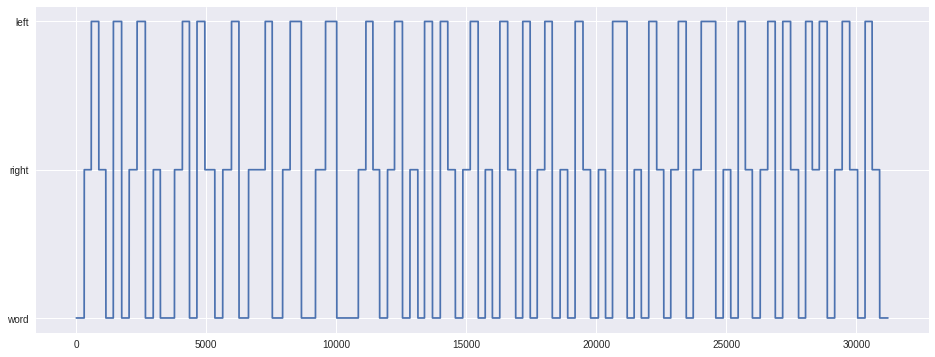

In [0]:
plt.figure(figsize=(16,6))
plt.plot(df_train_pcf['label'])
plt.show()

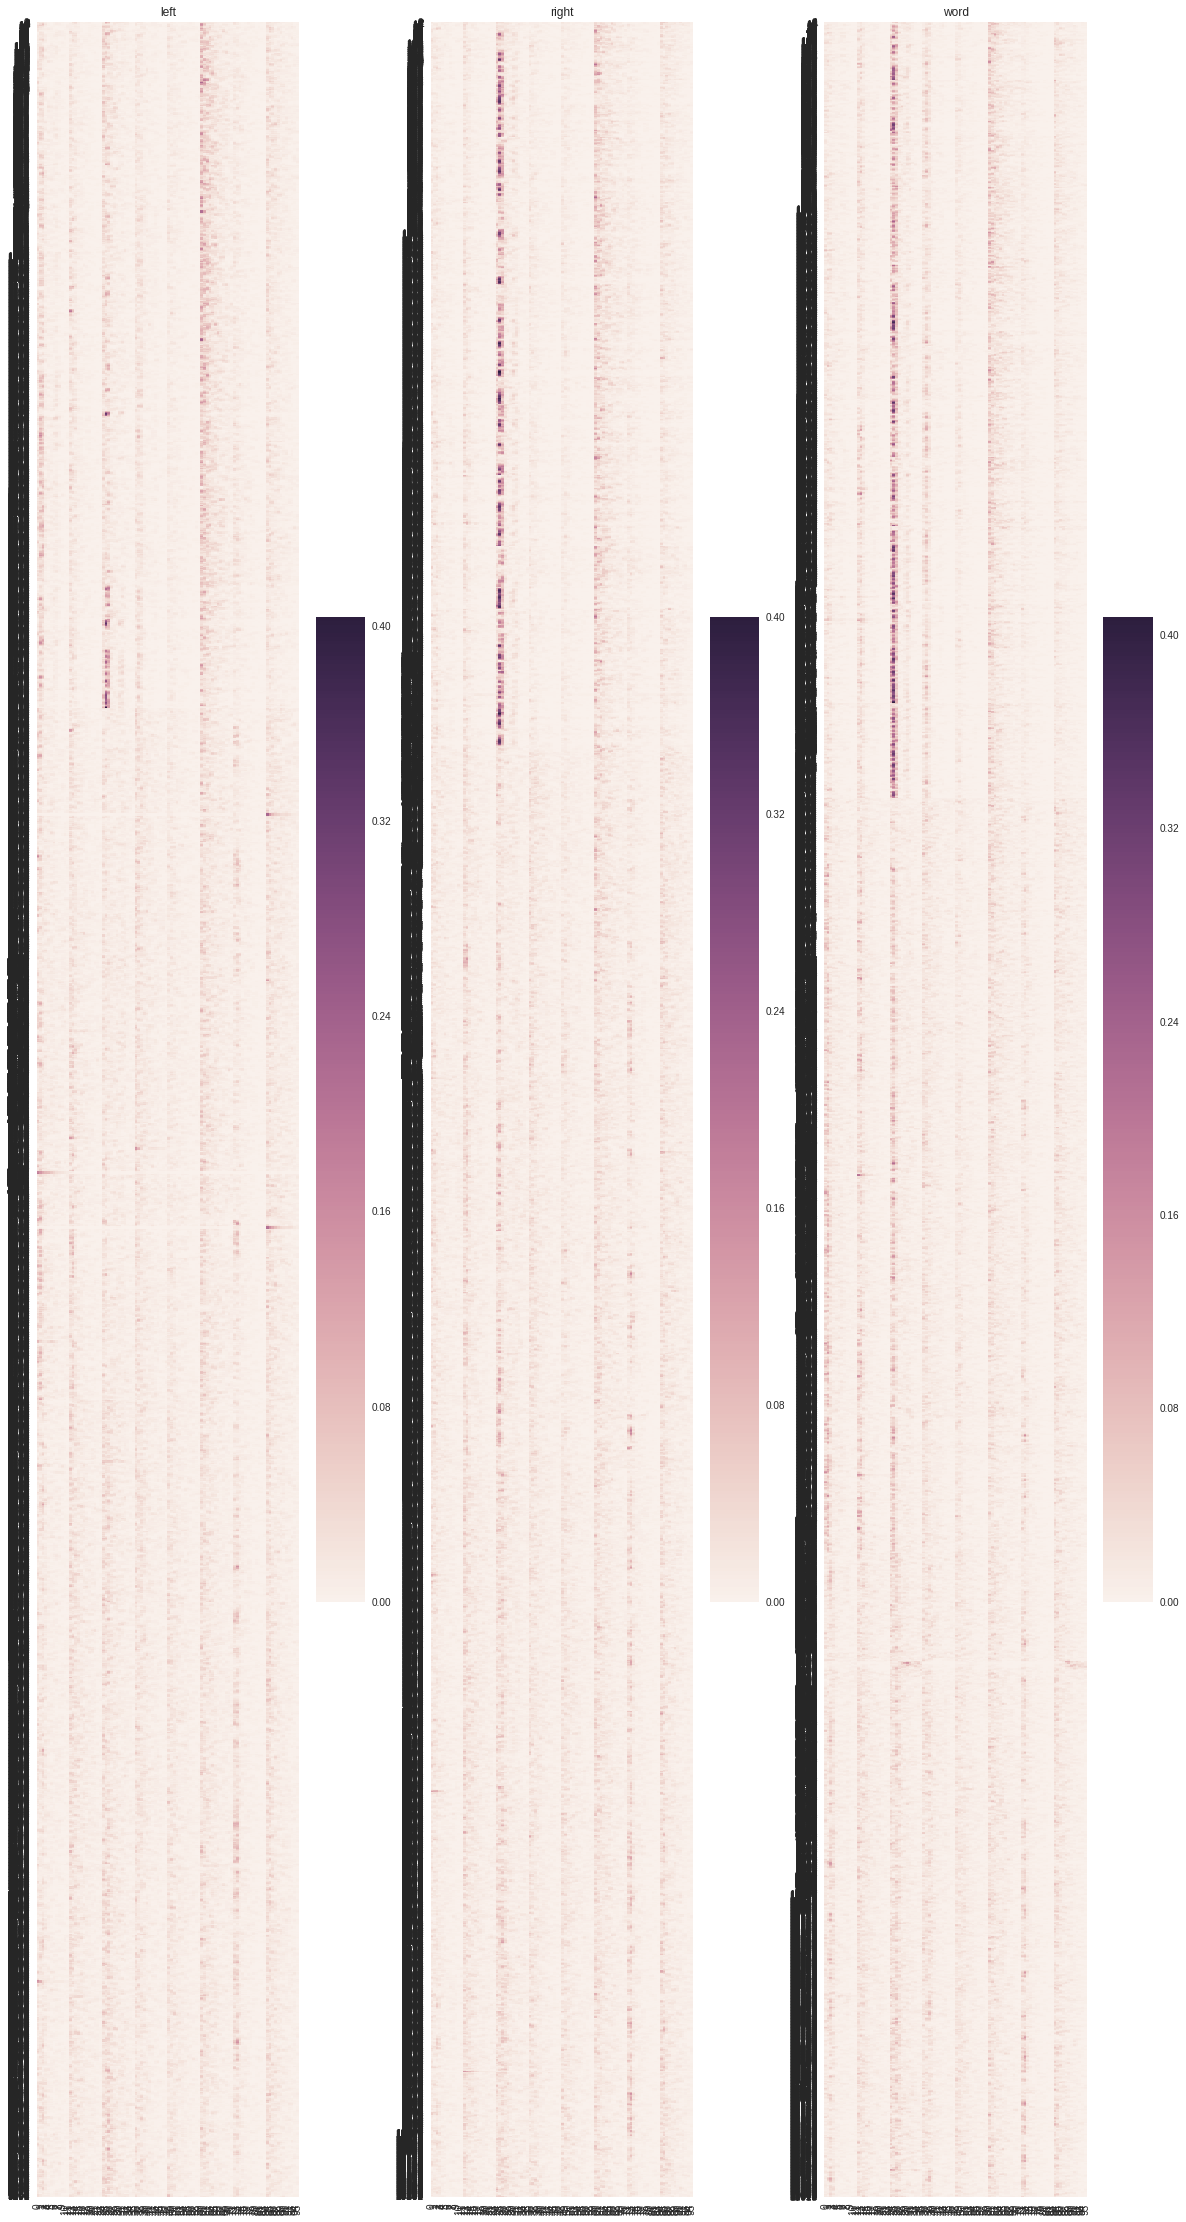

In [0]:
X = df_train_pcf.drop(columns=['label', 'session', 'subject']).values
plt.figure(figsize=(20,40))
for i, label in enumerate(label_dict.values()):
    plt.subplot(1, len(label_dict), i+1)
    plt.title(label)
    sns.heatmap(X[(df_train_pcf['label'] == label).values])
plt.show()

---
## PCA

In [0]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_pcf = pd.get_dummies(df_train_pcf, prefix=['subject', 'session'], columns=['subject', 'session']).drop(columns=['label']).values
X_pcf_sc = scaler.fit_transform(X_pcf)
y = df_train_pcf['label'].values

# Kernel PCA
X_pcf_pca_linear = KernelPCA(n_components=2, kernel='linear').fit_transform(X_pcf_sc)
X_pcf_pca_poly = KernelPCA(n_components=2, kernel='poly').fit_transform(X_pcf_sc)
X_pcf_pca_rbf = KernelPCA(n_components=2, kernel='rbf').fit_transform(X_pcf_sc)
X_pcf_pca_sigmoid = KernelPCA(n_components=2, kernel='sigmoid').fit_transform(X_pcf_sc)
X_pcf_pca_cosine = KernelPCA(n_components=2, kernel='cosine').fit_transform(X_pcf_sc)

In [0]:
# Your code goes here
def kde_2d_label(X_2d, y, s=2, alpha=0.5, lw=2, colors=None):
    """Visualuse a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    targets = np.unique(y)
    alpha = 1. if len(targets) == 1 else 0.5
    if colors is None or not (isinstance(colors, list) or isinstance(colors, str)):
        colors = sns.color_palette(n_colors=targets.size)
    elif isinstance(colors, str):
        colors = colors.split(',')
    for color, target in zip(colors, targets):
        sns.kdeplot(X_2d[y == target, 0], X_2d[y == target, 1], color=color,
                    legend=True, shade=True, shade_lowest=False, alpha=alpha, label=target)

In [0]:
fig = plt.figure(figsize=(16,20))

colors=['blue','orange','green']

ax = fig.add_subplot(5, 4, 1)
ax.set_title('Kernel PCA: linear')
kde_2d_label(X_pcf_pca_linear, y, colors=colors)
ax.legend()

ax = fig.add_subplot(5, 4, 2)
ax.set_title('Kernel PCA: linear, LEFT')
kde_2d_label(X_pcf_pca_linear[y == 'left'], y[y == 'left'], colors=colors[0])
ax.legend()

ax = fig.add_subplot(5, 4, 3)
ax.set_title('Kernel PCA: linear, RIGHT')
kde_2d_label(X_pcf_pca_linear[y == 'right'], y[y == 'right'], colors=colors[1])
ax.legend()

ax = fig.add_subplot(5, 4, 4)
ax.set_title('Kernel PCA: linear, WORD')
kde_2d_label(X_pcf_pca_linear[y == 'word'], y[y == 'word'], colors=colors[2])
ax.legend()

ax = fig.add_subplot(5, 4, 5)
ax.set_title('Kernel PCA: poly')
kde_2d_label(X_pcf_pca_poly, y, colors=colors)
ax.legend()

ax = fig.add_subplot(5, 4, 6)
ax.set_title('Kernel PCA: poly, LEFT')
kde_2d_label(X_pcf_pca_poly[y == 'left'], y[y == 'left'], colors=colors[0])
ax.legend()

ax = fig.add_subplot(5, 4, 7)
ax.set_title('Kernel PCA: poly, RIGHT')
kde_2d_label(X_pcf_pca_poly[y == 'right'], y[y == 'right'], colors=colors[1])
ax.legend()

ax = fig.add_subplot(5, 4, 8)
ax.set_title('Kernel PCA: poly, WORD')
kde_2d_label(X_pcf_pca_poly[y == 'word'], y[y == 'word'], colors=colors[2])
ax.legend()

ax = fig.add_subplot(5, 4, 9)
ax.set_title('Kernel PCA: rbf')
kde_2d_label(X_pcf_pca_rbf, y, colors=colors)
ax.legend()

ax = fig.add_subplot(5, 4, 10)
ax.set_title('Kernel PCA: rbf, LEFT')
kde_2d_label(X_pcf_pca_rbf[y == 'left'], y[y == 'left'], colors=colors[0])
ax.legend()

ax = fig.add_subplot(5, 4, 11)
ax.set_title('Kernel PCA: rbf, RIGHT')
kde_2d_label(X_pcf_pca_rbf[y == 'right'], y[y == 'right'], colors=colors[1])
ax.legend()

ax = fig.add_subplot(5, 4, 12)
ax.set_title('Kernel PCA: rbf, WORD')
kde_2d_label(X_pcf_pca_rbf[y == 'word'], y[y == 'word'], colors=colors[2])
ax.legend()

ax = fig.add_subplot(5, 4, 13)
ax.set_title('Kernel PCA: sigmoid')
kde_2d_label(X_pcf_pca_sigmoid, y, colors=colors)
ax.legend()

ax = fig.add_subplot(5, 4, 14)
ax.set_title('Kernel PCA: sigmoid, LEFT')
kde_2d_label(X_pcf_pca_sigmoid[y == 'left'], y[y == 'left'], colors=colors[0])
ax.legend()

ax = fig.add_subplot(5, 4, 15)
ax.set_title('Kernel PCA: sigmoid, RIGHT')
kde_2d_label(X_pcf_pca_sigmoid[y == 'right'], y[y == 'right'], colors=colors[1])
ax.legend()

ax = fig.add_subplot(5, 4, 16)
ax.set_title('Kernel PCA: sigmoid, WORD')
kde_2d_label(X_pcf_pca_sigmoid[y == 'word'], y[y == 'word'], colors=colors[2])
ax.legend()

ax = fig.add_subplot(5, 4, 17)
ax.set_title('Kernel PCA: cosine')
kde_2d_label(X_pcf_pca_cosine, y, colors=colors)
ax.legend()

ax = fig.add_subplot(5, 4, 18)
ax.set_title('Kernel PCA: cosine, LEFT')
kde_2d_label(X_pcf_pca_cosine[y == 'left'], y[y == 'left'], colors=colors[0])
ax.legend()

ax = fig.add_subplot(5, 4, 19)
ax.set_title('Kernel PCA: cosine, RIGHT')
kde_2d_label(X_pcf_pca_cosine[y == 'right'], y[y == 'right'], colors=colors[1])
ax.legend()

ax = fig.add_subplot(5, 4, 20)
ax.set_title('Kernel PCA: cosine, WORD')
kde_2d_label(X_pcf_pca_cosine[y == 'word'], y[y == 'word'], colors=colors[2])
ax.legend()

plt.show()

---
## MTTD

In [0]:
psd = df_train_pcf.drop(columns=['label', 'session', 'subject'])
psd_columns = psd.columns
psd_columns

In [0]:
psd_norm = df_train_pcf.copy()
for channel in pcf_channels:
    psd_norm[psd_norm.filter(regex=channel).columns] = psd_norm.filter(regex=channel).div(psd_norm.filter(regex=channel).sum(axis=1), axis='index')
psd_norm.head()

In [0]:
n = len(df_train_pcf)
n_l = df_train_pcf['label'].value_counts()
labels = n_l.keys()

m = psd_norm[psd_columns].mean()
m_l = { label: df_train_pcf[df_train_pcf['label'] == label][psd_columns].mean() for label in labels }

d = len(psd_columns) # number of feature
B = np.zeros((d, d))
W = np.zeros((d, d))
for label in labels:
    diff = np.array(m_l[label] - m).reshape((d, 1))
    B += n_l[label] * diff @ diff.T
    for i, psd in psd_norm.iterrows():
        diff = np.array(psd - m_l[label]).reshape((d, 1))
        W += diff @ diff.T

In [0]:
E, A = np.linalg.eigh(np.linalg.inv(W) @ B)
Y = np.array(psd_norm) @  A[:, E > 0]
Y